In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, boxcox
from math import exp, log
import os
from os import listdir
import csv
from sklearn.ensemble import RandomForestRegressor as RandomForest
%matplotlib inline
import pylab
from matplotlib.mlab import PCA as mlabPCA
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn import metrics

C:\Users\Piboditheowl\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Модель 1  Отделение 1005625
### Модель 2  Отделение 1005839
### Модель 3  Отделение 1006034
### Модель 4  Отделение 1006255
### Модель 5  Отделение 1005609


### Считываем данные

In [2]:
model1 = pd.read_csv('bracnh1_model.csv', header=0) # base8_nr900_p10¬_cleaned
model2 = pd.read_csv('bracnh2_model.csv', header=0) # base8_nr900_p10¬_cleaned
model3 = pd.read_csv('bracnh3_model.csv', header=0) # base8_nr900_p10¬_cleaned
model4 = pd.read_csv('bracnh4_model.csv', header=0) # base8_nr900_p10¬_cleaned
model5 = pd.read_csv('bracnh5_model.csv', header=0) # base8_nr900_p10¬_cleaned


In [3]:
sum(model4['count'][model4.Year==2013])

21228

In [4]:
sum(model3['count'][model3.Year==2014])

97980

In [5]:
sum(model3['count'][model3.Year==2015])

75594

In [6]:
sum(model1['count'][model1.Year==2014])

81502

### Выкидываем лишнюю колонку

In [7]:
model1 = model1.drop("bracnh1$EVENT_DTTM",axis=1)
model2 = model2.drop("bracnh2$EVENT_DTTM",axis=1)
model3 = model3.drop("bracnh3$EVENT_DTTM",axis=1)
model4 = model4.drop("bracnh4$EVENT_DTTM",axis=1)
model5 = model5.drop("bracnh5$EVENT_DTTM",axis=1)

In [8]:
model1.count = np.asarray(model1.iloc[:,0:1])
model2.count = np.asarray(model2.iloc[:,0:1])
model3.count = np.asarray(model3.iloc[:,0:1])
model4.count = np.asarray(model4.iloc[:,0:1])
model5.count = np.asarray(model5.iloc[:,0:1])

In [9]:
model5.shape

(8289, 5)

### Разбиваем на маркировку и обучающую выборку

In [10]:
train1=model1.iloc[:,1:5]
train2=model2.iloc[:,1:5]
train3=model3.iloc[:,1:5]
train4=model4.iloc[:,1:5]
train5=model5.iloc[:,1:5]
target1 = np.ravel(model1.iloc[:,0:1])
target2 = np.ravel(model2.iloc[:,0:1])
target3 = np.ravel(model3.iloc[:,0:1])
target4 = np.ravel(model4.iloc[:,0:1])
target5 = np.ravel(model5.iloc[:,0:1])

### Оценим распределение

# Одинаковое ли количество часов учтено

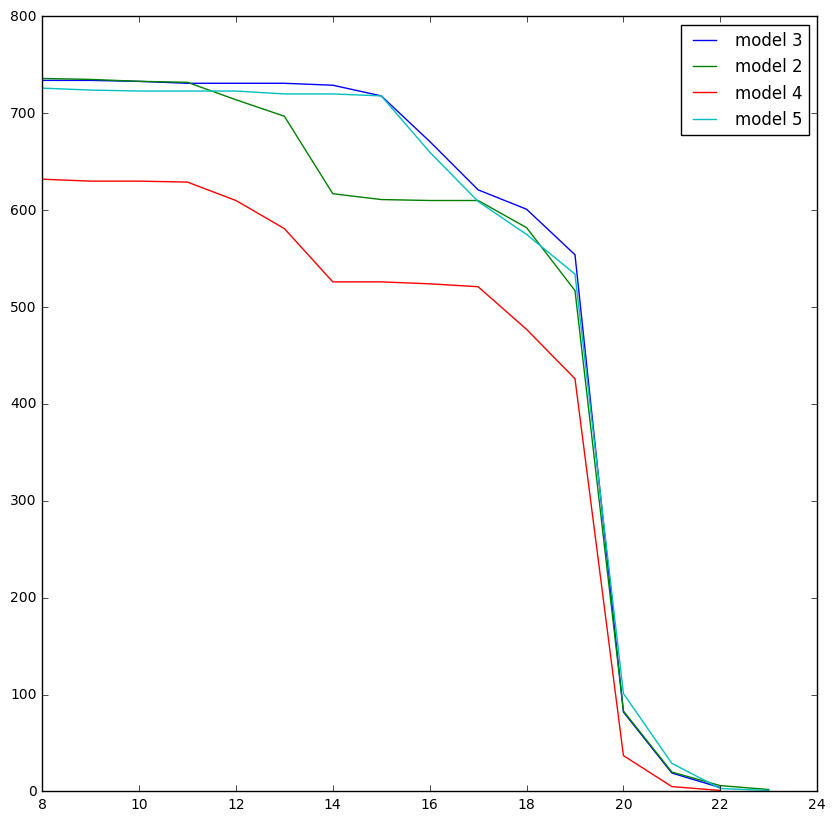

In [11]:
plt.figure(figsize=(10,10))
plt.plot(range(8,23),model3.Hour.value_counts(),label = 'model 3')
plt.plot(range(8,24),model2.Hour.value_counts(),label = 'model 2')
plt.plot(range(8,23),model4.Hour.value_counts(),label = 'model 4')
plt.plot(range(8,24),model5.Hour.value_counts(),label = 'model 5')
plt.xlabel='1-st Component'
plt.legend(loc='upper right')


(array([  2.58400000e+03,   1.20000000e+02,   2.49000000e+02,
          1.13000000e+02,   2.00000000e+01,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   97.9,  194.8,  291.7,  388.6,  485.5,  582.4,  679.3,
         776.2,  873.1,  970. ]),
 <a list of 10 Patch objects>)

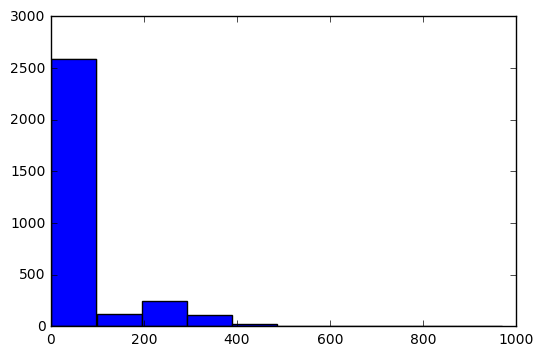

In [12]:
plt.hist(target1)

(array([  1.81700000e+03,   2.53400000e+03,   2.13100000e+03,
          1.13000000e+03,   2.98000000e+02,   7.70000000e+01,
          1.30000000e+01,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  1. ,  10.3,  19.6,  28.9,  38.2,  47.5,  56.8,  66.1,  75.4,
         84.7,  94. ]),
 <a list of 10 Patch objects>)

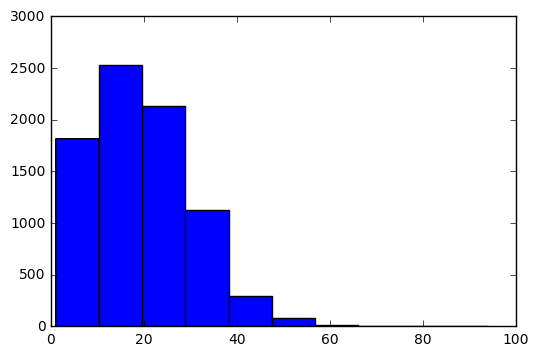

In [13]:
plt.hist(target2)

(array([  2.03600000e+03,   3.54000000e+03,   2.12200000e+03,
          5.77000000e+02,   9.90000000e+01,   1.40000000e+01,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   1.,   16.,   31.,   46.,   61.,   76.,   91.,  106.,  121.,
         136.,  151.]),
 <a list of 10 Patch objects>)

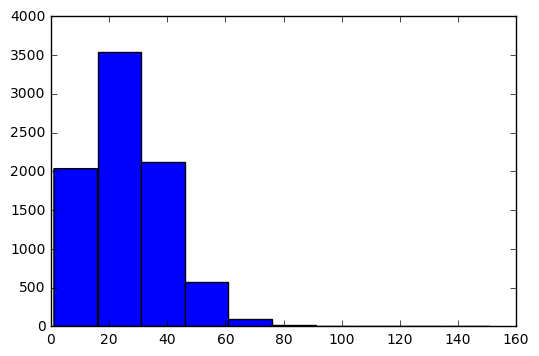

In [14]:
plt.hist(target3)

(array([ 1281.,  1427.,  1517.,  1344.,   659.,   308.,   145.,    47.,
           20.,     7.]),
 array([  1. ,   6.3,  11.6,  16.9,  22.2,  27.5,  32.8,  38.1,  43.4,
         48.7,  54. ]),
 <a list of 10 Patch objects>)

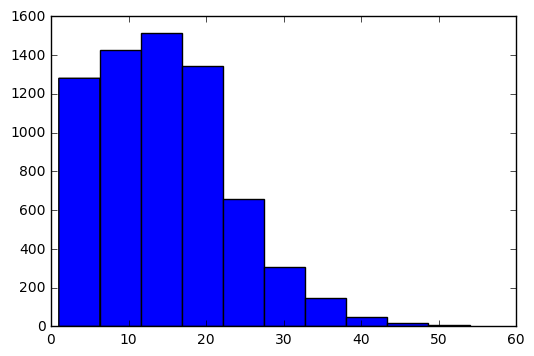

In [15]:
plt.hist(target4)

(array([  1.75000000e+03,   2.55300000e+03,   2.24200000e+03,
          1.16300000e+03,   4.13000000e+02,   1.25000000e+02,
          2.80000000e+01,   9.00000000e+00,   4.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   11.2,   21.4,   31.6,   41.8,   52. ,   62.2,   72.4,
          82.6,   92.8,  103. ]),
 <a list of 10 Patch objects>)

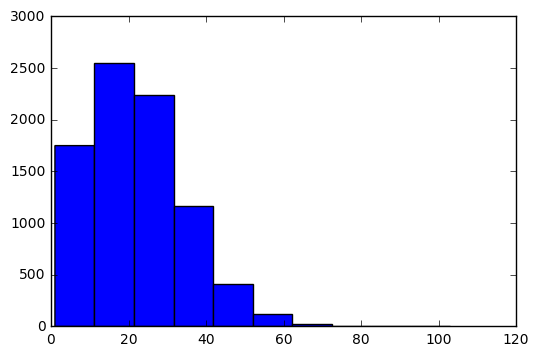

In [19]:
plt.hist(target5)

### Есть явная аномалия с первым набором образцом. Остальные можно почистить - но стоит уточнить, возможно изредка возможно такое большое количество посещений ~100. Очевидно однако, что 900 посещений в час ночи - ошибка в записи данных

### Когда происходит аномалия

In [20]:
model1.Hour.value_counts()

9     275
8     235
15    229
13    229
14    228
11    228
10    228
12    227
16    226
17    224
18    197
19    175
7      81
4      52
3      50
6      48
5      47
2      47
1      39
20     23
21      3
Name: Hour, dtype: int64

In [21]:
model1_2 = model1[model1.count>140]
model1_2.Hour.value_counts() #В эти часы, причем явно это не рабочие часы


7    74
9    71
8    65
4    50
3    48
2    46
6    43
5    39
1    38
Name: Hour, dtype: int64

### Посмотрим на паттерны

In [22]:
list = []
list.append(model2)
list.append(model3)
list.append(model4)
list.append(model5)
t = np.zeros((16,1))

In [23]:
for j in list: #посчитаем количество посещаний для каждого часа
    #print '---------------------------------------'
    for i in np.arange(8,24):
            #print i,"ч.", sum(j[j.Hour==i]["count"])
            t[i-8]+=sum(j[j.Hour==i]["count"])

In [24]:
coef = np.zeros((16,2)) #посещений в час/сколько всего посещений
coef[:,0]=np.arange(8,24)
for i in np.arange(0,16):
    #print t[i]/sum(t)
    coef[i,1]=t[i]/sum(t)

plt.plot(np.arange(8,24),coef[:,1]*100)
plt.xlabel('TIME')
plt.ylabel('% FROM TOTAL')

### Создадим массив c  коэффициентами для каждого часа и умножим на количество посещений в этот день

In [25]:
z=0
for i in np.arange(1,10):
    z+= len(model1[model1.Hour==i])
#sum(model1.Hour.unique()>9) # количество разных часов
x = np.zeros((z*16,5))
total = model1[model1.Hour==1] # объединим аномальные массивы где часы от 1 до 10 включительно
for i in np.arange(2,10):
    total = total.append(model1[model1.Hour==i])

In [28]:
for i in np.arange(0,z*16,16):
        x[0+i:16+i,0]=coef[:,1]#записываем коэффициенты
        x[0+i:16+i,4] = coef[:,0] #записываем часы новые

In [29]:
j=0  #количество посещений в день
for i in np.arange(0,z*16,16):
    x[0+i:16+i,0]=x[0+i:16+i,0]*total.iloc[j,0]  #количество посещений
    x[0+i:16+i,1:4]=total.iloc[j,1:4]  #год месяц день
    j+=1

In [30]:
df =pd.DataFrame(x)
df.columns=['count','Year','Month','Day','Hour']

In [31]:
new_model1 = model1[model1.Hour==10][model1.Year==2015] # cjzz
for i in np.arange(11,24):
    new_model1 = new_model1.append(model1[model1.Hour==i])

C:\Users\Piboditheowl\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [32]:
new_model1["Month"].value_counts()

12    738
10    703
11    624
Name: Month, dtype: int64

In [ ]:
data.Party.value_counts().plot(kind="bar", label='Original')
df.Party.value_counts().plot(kind="bar", rot=0,color='g',label='Cleaned')
pyplot.legend(loc='upper right')

In [33]:
new_model1.shape

(2065, 5)

In [34]:
new_model1 = new_model1.append(df)
new_model1.to_csv('task.csv', index=None)


### Данные агрегированы в R и снова загружены для построения модели

In [35]:
model1_new = pd.read_csv('bracnh1_final.csv', header=0) 
train_new=model1_new.iloc[:,1:5]
target_new = np.ravel(model1_new.iloc[:,0:1])

### Посмотрим на распределение посли очистки -  стало гораздо лучше

(array([  1.48900000e+03,   2.71600000e+03,   2.75400000e+03,
          9.02000000e+02,   2.46000000e+02,   6.00000000e+01,
          1.70000000e+01,   1.90000000e+01,   1.10000000e+01,
          2.00000000e+00]),
 array([   1.        ,   11.5524009 ,   22.1048018 ,   32.6572027 ,
          43.2096036 ,   53.7620045 ,   64.3144054 ,   74.86680629,
          85.41920719,   95.97160809,  106.52400899]),
 <a list of 10 Patch objects>)

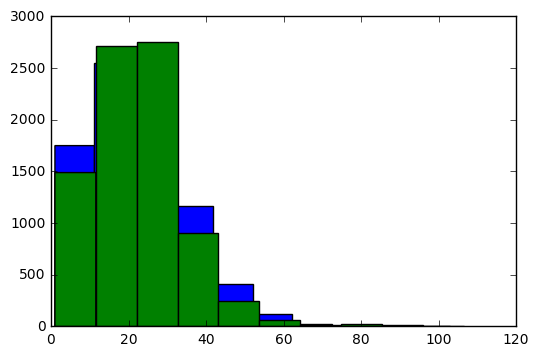

In [46]:
plt.hist(target5,bins=10)
plt.hist(target_new,bins=10)


### Доовльно много данных где количество посещений очень маленькое

In [ ]:
model1_new.Hour.value_counts()

In [ ]:
model1_new.shape

### Основная масса приходится на 20-23 и 8-9. Что действительно соотвествует истине. Их можно исключить из выборки, не будем однако тратить время, на итоговый результат особого влияния они оказывать не должны

### Кросс Валидация RMSE до обработки 52 - см.ниже, после = 9

In [ ]:
aggr = model1_new.groupby(['Hour']).sum()

In [ ]:
hr = model1_new.Hour.value_counts()
hr = hr.sort_index()
hr

In [ ]:
test = aggr["count"]/hr

In [ ]:
hrm

In [ ]:
hi =np.zeros((1,12))
t=0
for i in xrange(8,20):
    #for j in xrange(0,8216):
    
    vos = abs(model1_new['count'][model1_new.Hour==i] - hrm[i])
    x= math.sqrt(sum(vos.values**2)/len(vos))
    t=t+x
    hi[0,i-8]=x

In [ ]:
v = np.zeros((2,14))

In [ ]:
v[0,:]= hrm.index

In [ ]:
v[1,0:12]= hi

In [ ]:
k = pd.DataFrame(v)

In [ ]:
t/12

In [ ]:
from sklearn.cross_validation import KFold
from sklearn import cross_validation
model = RandomForest(n_estimators=100,random_state=42)
kf = KFold(len(target_new), n_folds=5)
results= cross_validation.cross_val_predict(model, train_new, target_new, cv=kf, n_jobs=-1)
print 'RMSE for model 1   ', math.sqrt(sum((results-target_new)**2)/len(target_new))

In [ ]:
x = 100*abs(results-target_new)/target_new

In [ ]:
y = 100*abs(np.mean(target_new)-target_new)/target_new

In [ ]:
np.mean(y)

In [ ]:
np.mean(x)

In [ ]:
plt.figure(figsize=(15,15))
plt.hist(results-target_new,bins=20,range=[-50,50])

In [ ]:
plt.figure(figsize=(25,15))
plt.plot(xrange(0,8216),target_new,c="r")
plt.plot(xrange(0,8216),results,c="g")


In [ ]:
plt.figure(figsize=(25,15))
plt.plot(xrange(0,8216),results-target_new)

In [ ]:
target_new.shape

### Построим модели
### Модель rf_new  Отделение 1005625
### Модель rf2         Отделение 1005839
### Модель rf3         Отделение 1006034
### Модель rf4         Отделение 1006255
### Модель rf5         Отделение 1005609


In [ ]:
rf1 = RandomForest(n_estimators=100)
rf1.fit(train1,target1)
rf2 = RandomForest(n_estimators=100)
rf2.fit(train2,target2)
rf3 = RandomForest(n_estimators=100)
rf3.fit(train3,target3)
rf4 = RandomForest(n_estimators=100)
rf4.fit(train4,target4)
rf5 = RandomForest(n_estimators=100)
rf5.fit(train5,target5)
rf_new = RandomForest(n_estimators=100)
rf_new.fit(train_new,target_new)

### Какой прогноз дает модель на 10:00 на 15.01.2016 в отделения 1005625? А на 11:00? А на 12:00 на 16.01.2016? А на 30 декабря 2016 в 15 часов

In [ ]:
rf_new = RandomForest(n_estimators=100,max_depth=20)
rf_new.fit(train_new,target_new)

In [ ]:
v=[]
for j in xrange(1,13):   
    for i in xrange(1,32):
        t=0
        for k in xrange(8,22):
            x = np.array([[2016,j,i,k]])
            t+=rf_new.predict(x)
        #x = np.array([[2016,1,15,10],[2016,1,15,11],[2016,1,16,11],[2016,12,30,15]])
        v.append(t)
        #print rf_new.predict(x)

In [ ]:
s = np.array(v)
s.shape

In [ ]:
plt.hist(s)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(xrange(1,373),s)

In [ ]:
parameters={'learning_rate':[1e-1],'min_samples_split':[7],'max_depth':[10],'min_samples_leaf':[3],'subsample':[1.0],'loss':['ls'],'n_estimators':[100]}

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import grid_search

clf = grid_search.GridSearchCV(GradientBoostingRegressor(),parameters) 

clf.fit(train_new, target_new)

In [ ]:
from sklearn.cross_validation import KFold
from sklearn import cross_validation
model = clf
kf = KFold(len(target_new), n_folds=5)
results= cross_validation.cross_val_predict(model, train_new, target_new, cv=kf, n_jobs=-1)
print 'RMSE for model 1   ', math.sqrt(sum((results-target_new)**2)/len(target_new))

In [ ]:
x = np.array([[2019,2,15,10],[2015,2,15,10],[2014,2,15,10],[2013,1,15,10]])

In [ ]:
clf.predict (x)
#rf_new.predict(x)

 ###  Подсчитаем расхождения если не чистить модели. Теоретически случайный лес не переобучается выше определенного, некритического предела

In [ ]:
res1 = rf1.predict(train1)- target1
res2 = rf2.predict(train2)- target2
res3 = rf3.predict(train3)- target3
res4 = rf4.predict(train4)- target4
res5 = rf5.predict(train5)- target5

### Подсчитаем метрику RMSE в целом

In [ ]:
RMSE1 = math.sqrt(sum(res1**2)/len(target1))
RMSE2 = math.sqrt(sum(res2**2)/len(target2))
RMSE3 = math.sqrt(sum(res3**2)/len(target3))
RMSE4 = math.sqrt(sum(res4**2)/len(target4))
RMSE5 = math.sqrt(sum(res5**2)/len(target5))

In [ ]:
print "RMSE 1 withouth preprocessing  ",RMSE1,"RMSE 2  ",RMSE2,"RMSE 3  ",RMSE3,"RMSE 4  ",RMSE4,"RMSE 5  ",RMSE5

### Кросс Валидация

In [ ]:
model = RandomForest(n_estimators=100,random_state=42)
kf = KFold(len(target1), n_folds=5)
results= cross_validation.cross_val_predict(model, train1, target1, cv=kf, n_jobs=-1)
print 'RMSE for model 1 old   ', math.sqrt(sum((results-target1)**2)/len(target1))
kf = KFold(len(target2), n_folds=5)
results= cross_validation.cross_val_predict(model, train2, target2, cv=kf, n_jobs=-1)
print 'RMSE for model 2   ', math.sqrt(sum((results-target2)**2)/len(target2))
kf = KFold(len(target3), n_folds=5)
results= cross_validation.cross_val_predict(model, train3, target3, cv=kf, n_jobs=-1)
print 'RMSE for model 3   ', math.sqrt(sum((results-target3)**2)/len(target3))
kf = KFold(len(target4), n_folds=5)
results= cross_validation.cross_val_predict(model, train4, target4, cv=kf, n_jobs=-1)
print 'RMSE for model 4   ', math.sqrt(sum((results-target4)**2)/len(target4))
kf = KFold(len(target5), n_folds=5)
results= cross_validation.cross_val_predict(model, train5, target5, cv=kf, n_jobs=-1)
print 'RMSE for model 5   ', math.sqrt(sum((results-target5)**2)/len(target5))

### Если посмотреть на гистограммы распределений и RMSE моделей видно, что RMSE больше именно там, где присуствутют выбросы с аномально высоким количеством посещений в час. Однако прежде чем их удалять, следует проконсультироваться с бизнесом и понять причину: ошибка записи? Специфичный наплыв клиентво именно в эти дни? Ошибка не столь явно выражение как в отделении  1005625 . Скорее всего,  если убрать  выбросы, можно улучшить метрику на 2-3 пункта и сделать равной отделению 1006255 и 1005625 после очистки  . Но повторяюсь, нужно понимать их причину

### Сохраняем модели

In [ ]:
#pickle.dump(rf_new,open('1005625.pkl','wb'))
#pickle.dump(rf2,open('1005839.pkl','wb'))
#pickle.dump(rf3,open('1006034.pkl','wb'))
#pickle.dump(rf4,open('1006255.pkl','wb'))
#pickle.dump(rf5,open('1005609.pkl','wb'))
#pickle.dump(rf1,open('1005609_with_outliers.pkl','wb'))


### Эксперимет с временными рядами. К задаче не относится напрямую

In [2]:
from pandas import read_csv, DataFrame
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics


In [3]:
dataset = read_csv('final.csv',',', parse_dates=['time'],index_col=['time'],dayfirst=False)

C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app
C:\Users\Piboditheowl\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    8216.000000
mean       22.279181
std        11.843402
min         1.000000
25%              NaN
50%              NaN
75%              NaN
max       106.524009
Name: Cnt, dtype: float64

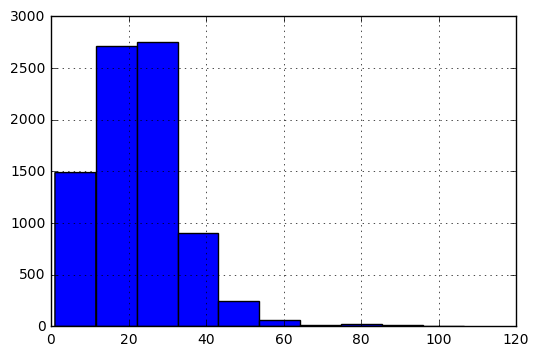

In [4]:
otg = dataset.Cnt
otg = otg.resample('H', how='mean')
itog = otg.describe()
otg.hist()
itog


In [5]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(otg)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)

 JB p-value skew kurtosis
-------------------------
nan   nan   nan    nan   
-------------------------


In [68]:
otg1diff = otg.diff(periods=1).dropna()


In [69]:
test = sm.tsa.adfuller(otg1diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

('adf: ', -9.7423395372672861)
('p-value: ', 8.4305336768447939e-17)
('Critical values: ', {'5%': -2.8619279840245726, '1%': -3.4312279431328334, '10%': -2.5669765195270937})
единичных корней нет, ряд стационарен


In [70]:
m = otg1diff.index[len(otg1diff.index)/2+1]
r1 = sm.stats.DescrStatsW(otg1diff[m:])
r2 = sm.stats.DescrStatsW(otg1diff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

('p-value: ', 0.0055076270034828236)


In [73]:
src_data_model = np.exp(otg1diff)
model = ARIMA(src_data_model, order=(5, 1, 2),freq='W').fit(disp=0)

In [76]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

      Q-stat   p-value
0   0.000256  0.987241
1   0.000505  0.999747
2   0.000759  0.999994
3   0.001008  1.000000
4   0.001256  1.000000
5   0.001510  1.000000
6   0.001756  1.000000
7   0.002009  1.000000
8   0.002254  1.000000
9   0.002506  1.000000
10  0.002750  1.000000
11  0.003001  1.000000
12  0.003244  1.000000
13  0.003493  1.000000
14  0.003735  1.000000
15  0.003983  1.000000
16  0.004224  1.000000
17  0.004472  1.000000
18  0.004712  1.000000
19  0.004958  1.000000
20  0.005196  1.000000
21  0.005442  1.000000
22  0.005679  1.000000
23  0.005923  1.000000
24  0.006160  1.000000
25  0.006403  1.000000
26  0.006638  1.000000
27  0.006880  1.000000
28  0.007115  1.000000
29  0.007356  1.000000
30  0.007589  1.000000
31  0.007829  1.000000
32  0.008061  1.000000
33  0.008300  1.000000
34  0.008532  1.000000
35  0.008769  1.000000
36  0.009000  1.000000
37  0.009236  1.000000
38  0.009466  1.000000
39  0.009701  1.000000


In [83]:
pred = model.predict('2013-08-26 10:00:00','2014-12-31 11:00:00')


ValueError: Wrong number of items passed 4210, placement implies 70

In [22]:
data = read_csv('final.csv',',', parse_dates=['time'],index_col=['time'],dayfirst=False)

In [23]:
ts = data.Cnt
plt.figure(figsize=(100,10))
#plt.plot(ts)

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


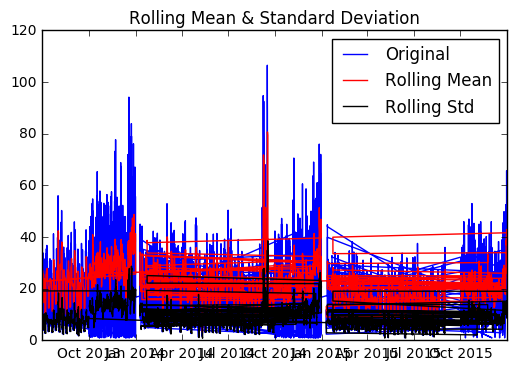

Results of Dickey-Fuller Test:
Test Statistic                -8.491914e+00
p-value                        1.306516e-13
#Lags Used                     3.700000e+01
Number of Observations Used    8.178000e+03
Critical Value (5%)           -2.861893e+00
Critical Value (1%)           -3.431150e+00
Critical Value (10%)          -2.566958e+00
dtype: float64


In [25]:
test_stationarity(ts)

C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()


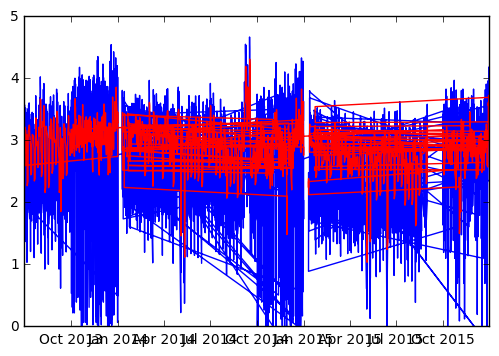

In [26]:
ts_log = np.log(ts)
#plt.plot(ts_log)
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')


C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


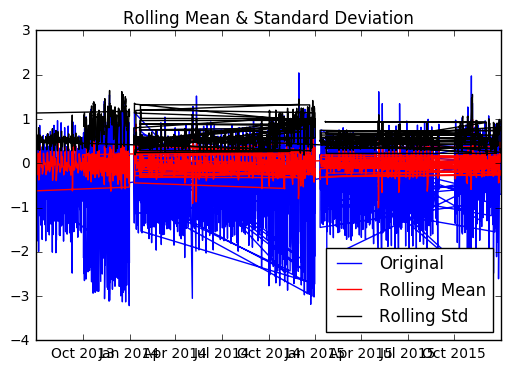

Results of Dickey-Fuller Test:
Test Statistic                  -20.412274
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8167.000000
Critical Value (5%)              -2.861894
Critical Value (1%)              -3.431151
Critical Value (10%)             -2.566958
dtype: float64


C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()


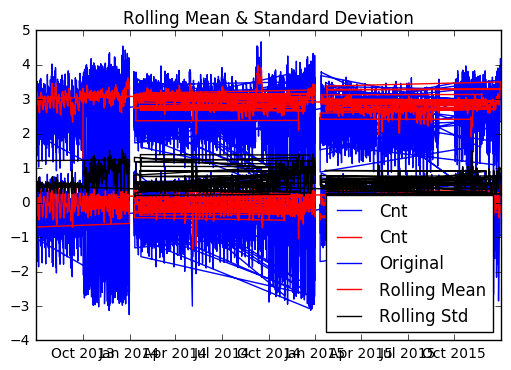

Results of Dickey-Fuller Test:
Test Statistic                -1.855665e+01
p-value                        2.089582e-30
#Lags Used                     3.700000e+01
Number of Observations Used    8.178000e+03
Critical Value (5%)           -2.861893e+00
Critical Value (1%)           -3.431150e+00
Critical Value (10%)          -2.566958e+00
dtype: float64


In [27]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Piboditheowl\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


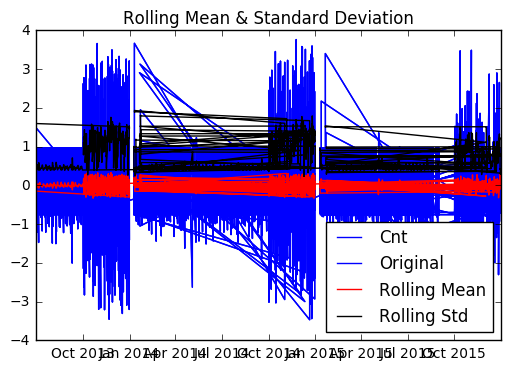

Results of Dickey-Fuller Test:
Test Statistic                  -25.542564
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    8179.000000
Critical Value (5%)              -2.861893
Critical Value (1%)              -3.431150
Critical Value (10%)             -2.566958
dtype: float64


In [28]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [29]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=37)
lag_pacf = pacf(ts_log_diff, nlags=37, method='ols')

C:\Users\Piboditheowl\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


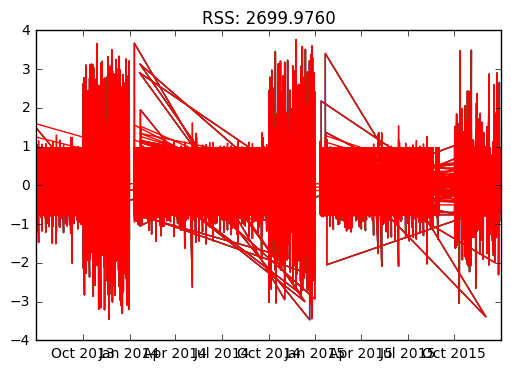

In [31]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0),freq='W')
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

model = ARIMA(ts_log, order=(0, 1, 2),freq='W')   #freq='W').fit(full_output=False, disp=0)
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

model = ARIMA(ts_log, order=(2, 1, 2),freq='W')  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [32]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

time
2013-10-01 10:00:00   -0.000047
2013-10-01 11:00:00   -0.385613
2013-10-01 12:00:00   -0.728367
2013-10-01 13:00:00   -0.631552
2013-10-01 14:00:00   -0.560750
dtype: float64


In [33]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

time
2013-10-01 10:00:00   -0.000047
2013-10-01 11:00:00   -0.385660
2013-10-01 12:00:00   -1.114027
2013-10-01 13:00:00   -1.745579
2013-10-01 14:00:00   -2.306329
dtype: float64


In [34]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

time
2013-07-01 08:00:00   -15.515754
2013-07-01 09:00:00   -14.698925
2013-07-01 10:00:00   -14.510883
2013-07-01 11:00:00   -14.569193
2013-07-01 12:00:00   -14.716139
dtype: float64

In [48]:
results_AR.predict(start="2013-07-01 08:00:00",end="2013-08-01 08:00:00")

ValueError: Wrong number of items passed 325, placement implies 4

In [135]:
predictions_ARIMA_diff = pd.Series("2014-12-31 14:00:00", copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


In [136]:
predictions_ARIMA_diff

0    2014-12-31 14:00:00
dtype: object

In [128]:
model.predict('2015-11-31 14:00:00','2015-12-31 14:00:00')

ValueError: cannot slice a 0-d array

In [13]:
test = sm.tsa.adfuller(otg1diff)
print 'adf: ', test[0]
print 'p-value: ', test[1]
print'Critical values: ', test[4]
if test[0]> test[4]['5%']: 
    print 'есть единичные корни, ряд не стационарен'
else:
    print 'единичных корней нет, ряд стационарен'

adf:  -9.74233953727
p-value:  8.43053367684e-17
Critical values:  {'5%': -2.8619279840245726, '1%': -3.4312279431328334, '10%': -2.5669765195270937}
единичных корней нет, ряд стационарен


In [14]:
m = otg1diff.index[len(otg1diff.index)/2+1]
r1 = sm.stats.DescrStatsW(otg1diff[m:])
r2 = sm.stats.DescrStatsW(otg1diff[:m])
print 'p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1]

p-value:  0.00550762700348


In [15]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()

In [16]:
src_data_model = otg1diff
from statsmodels.tsa.arima_model import ARIMA


In [63]:
model = sm.tsa.ARIMA(otg1diff, order=(5, 1, 1)).fit()


C:\Users\Piboditheowl\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [68]:
model.predict('2016-12-31 14:00:00', "2016-12-31 14:00:00")

ValueError: There is no frequency for these dates and date 2016-12-31 14:00:00 is not in dates index. Try giving a date that is in the dates index or use an integer

In [43]:
pred = model.predict('2015-12-31 14:00:00',2)

In [45]:
pred

Series([], dtype: float64)

In [ ]:
predict_sunspots20

In [ ]:
results_AR = model.fit(disp=0) 

In [ ]:
plt.figure(figsize=(100,10))
plt.plot(otg1diff)
plt.plot(results_AR.fittedvalues, color='red')


In [ ]:
ts_log = np.log(otg1diff)


In [ ]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [ ]:
dataset = read_csv('final.csv',',', parse_dates=['time'],index_col=['time'])

In [ ]:
test = dataset.iloc[0:4000,:]

In [ ]:
otg_test = test.resample('H', how='mean')

In [ ]:
otg_test.shape

In [ ]:
testdiff = otg_test.diff(periods=1).dropna()

In [ ]:
test_log = np.log(testdiff)

In [ ]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(test_log.ix[0], index=test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [ ]:
pre=predictions_ARIMA_log.dropna()

In [ ]:

preds=model.predict("2014-10-17 11:00:00","2015-10-17 14:00:00 ")

In [ ]:
preds

In [ ]:
pred = results_AR.predict(start='2013-07-01 09:00:00',end='2013-07-01 10:00:00')

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(otg1diff)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-otg1diff)**2)/len(otg1diff)))